In [36]:
import json
import requests
import re
from IPython import display
from datetime import datetime

import pandas as pd
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score

In [2]:
FIREBASE_PRIVATE_KEY = r'C:\Users\johnp\Documents\ESportsAnalytics\esportsanalytics-3b04cf0c1d47.json'
BASE_URL = 'https://api.opendota.com/api/'
TEAMS = 'teams'
HEROES = 'heroes'
PROPLAYERS = 'proPlayers'
PROMATCHES = 'proMatches'
MATCHES = 'matches'
PLAYERS = 'players'
HEROES_STATS = 'heroStats'

In [3]:
# read team OG matches file
with open(r'C:\Users\johnp\Documents\ESportsAnalytics\team_og_matches.json', 'r', encoding="utf-8") as input_file:

    data = input_file.read()
    team_og_matches_json = json.loads(data)

In [4]:
def match_outcome(radiant_win, radiant):
    if ((radiant_win == False and radiant == False) or (radiant_win == True and radiant == True)):
        return True
    
    elif ((radiant_win == True and radiant == False) or (radiant_win == False and radiant == True)):
        return False

In [5]:
error_list = []

for index, item in enumerate(team_og_matches_json):

    predict_players_mmr_total = 0
    predict_players_mmr_count = 0
    for x, i in enumerate(item['predict_players']):

        try:
            predict_players_mmr_total += i['player_stats']['mmr_estimate']['estimate']
            predict_players_mmr_count += 1

        except:

            error_list.append(index)
            
    # get the average MMR of the team
    team_og_matches_json[index]['predict_players_mmr_average'] = predict_players_mmr_total / predict_players_mmr_count

    opposing_players_mmr_total = 0
    opposing_players_mmr_count = 0
    for y, j in enumerate(item['opposing_players']):

        try:
            opposing_players_mmr_total += j['player_stats']['mmr_estimate']['estimate']
            opposing_players_mmr_count += 1

        except:

            error_list.append(index)
            
    team_og_matches_json[index]['opposing_players_mmr_average'] = opposing_players_mmr_total / opposing_players_mmr_count
    
    
    predict_team_total_matches = item['predict_team_stat'][0]['predict_team_wins_total'] + item['predict_team_stat'][0]['predict_team_losses_total']
    team_og_matches_json[index]['predict_team_total_matches'] = predict_team_total_matches
    
    predict_team_win_pct = round(item['predict_team_stat'][0]['predict_team_wins_total'] / predict_team_total_matches * 100, 2)
    team_og_matches_json[index]['predict_team_win_pct'] = predict_team_win_pct
    
    opposing_team_total_matches = item['opposing_team_stat'][0]['opposing_team_wins_total'] + item['opposing_team_stat'][0]['opposing_team_losses_total']
    team_og_matches_json[index]['opposing_team_total_matches'] = opposing_team_total_matches 
    
    opposing_team_win_pct =  round(item['opposing_team_stat'][0]['opposing_team_wins_total'] / opposing_team_total_matches * 100, 2)
    team_og_matches_json[index]['opposing_team_win_pct'] = opposing_team_win_pct

In [6]:
for i in team_og_matches_json[0]:
    print(i)

match_id
radiant_win
radiant
duration
start_time
leagueid
league_name
cluster
opposing_team_id
opposing_team_name
opposing_team_logo
predict_players
opposing_players
opposing_team_stat
predict_team_stat
predict_players_mmr_average
opposing_players_mmr_average
predict_team_total_matches
predict_team_win_pct
opposing_team_total_matches
opposing_team_win_pct


In [7]:
# Convert the team matches json to a dataframe
def team_matches_df(team_matches_json, predict_team_name, predict_team_id):
    
    all_matches_df = pd.DataFrame(data = [(datetime.fromtimestamp(item['start_time']).strftime('%Y-%m-%d %H:%M:%S'),
                                                       predict_team_name,
                                                       predict_team_id,
                                                       item['predict_team_total_matches'],
                                                       item['predict_team_win_pct'],
                                                       item['predict_team_stat'][0]['predict_team_rating'],
                                                       item['predict_players_mmr_average'],
                                                       item['opposing_team_name'],
                                                       item['opposing_team_id'],
                                                       item['opposing_team_total_matches'],
                                                       item['opposing_team_win_pct'],
                                                       item['opposing_team_stat'][0]['opposing_team_rating'],
                                                       item['opposing_players_mmr_average'],
                                                       item['league_name'],
                                                       item['leagueid'],
                                                       item['cluster'], 
                                                       item['radiant_win'],
                                                       item['radiant'],
                                                       item['duration'], 
                                                       item['match_id'],
                                                       match_outcome(item['radiant_win'], item['radiant'])) for index, item in enumerate(team_matches_json)], 
                      columns = ['start_date', 
                                 'predict_team_name', 
                                 'predict_team_id', 
                                 'predict_team_total_matches', 
                                 'predict_team_win_pct',
                                 'predict_team_rating',   
                                 'predict_players_mmr_average', 
                                 'opposing_team_name', 
                                 'opposing_team_id', 
                                 'opposing_team_total_matches',
                                 'opposing_team_win_pct', 
                                 'opposing_team_rating',
                                 'opposing_players_mmr_average', 
                                 'league_name', 
                                 'leagueid', 
                                 'cluster', 
                                 'radiant_win', 
                                 'radiant', 
                                 'duration', 
                                 'match_id', 
                                 'match_outcome'])
    
    return all_matches_df


In [8]:
og_team_matches_df = team_matches_df(team_og_matches_json, 'OG', 2586976)

In [9]:
og_team_matches_df.shape

(1335, 21)

In [10]:
def combine_team_matches_data(team_matches_json, predict_team_id):  
    matches_total = len(team_matches_json)
    count = 1
    
    # 1 x API CALL
    predict_team_stat = get_team_stat(predict_team_id)
    
    for index, value in enumerate(team_matches_json):
        
         # Check if we already maxed out our requests for that minute (only 60 requests per minute on the free tier)
        if (count%5 == 0):
            for i in range(60, -1, -1):
                print('Exceeded max API calls, please wait:', i, 'seconds                                                ', end = '\r')
                time.sleep(1)
                
            count = 1

        else:

            match_info = team_matches_json[index]
            
            # 1 x API CALL 
            match_info_detailed = get_match_info(match_info['match_id'])

            # 5 x API CALL (5 players)
            predict_players = [{'account_id' : player['account_id'], 
                                'name' : player['name'],
                                'player_stats' : get_player_info(player['account_id'])
                               } for player in match_info_detailed['players'] if player['isRadiant'] == match_info['radiant']]

            # 5 x API CALL (5 players)
            opposing_players = [{'account_id' : player['account_id'], 
                                 'name' : player['name'],
                                 'player_stats' : get_player_info(player['account_id'])
                                } for player in match_info_detailed['players'] if player['isRadiant'] != match_info['radiant']]

            team_matches_json[index]['predict_players'] = predict_players
            team_matches_json[index]['opposing_players'] = opposing_players

            # 1 x API CALL
            opposing_team_stat = get_team_stat(match_info['opposing_team_id'])
            
            opposing_team = [{'opposing_team_wins_total' : opposing_team_stat['wins'], 
                              'opposing_team_losses_total' : opposing_team_stat['losses'], 
                              'opposing_team_rating' : opposing_team_stat['rating']}]
            
            predict_team = [{'predict_team_wins_total' : predict_team_stat['wins'], 
                              'predict_team_losses_total' : predict_team_stat['losses'], 
                              'predict_team_rating' : predict_team_stat['rating'],
                              'predict_team_name' : predict_team_stat['name'], 
                              'predict_team_id' : predict_team_stat['team_id']}]
            
            team_matches_json[index]['opposing_team_stat'] = opposing_team
            team_matches_json[index]['predict_team_stat'] = predict_team

            print('match number:', index, 'downloaded', matches_total - index, 'matches left to go', round((index / matches_total) * 100, 2),'% complete', end = '\r')
            
            count += 1
         
    return team_matches_json

In [11]:
def get_match_info(match_id):
    response = requests.get(BASE_URL + MATCHES + '/' + str(match_id))

    try:
        match_info_json = json.loads(response.content.decode('utf-8'))

    except requests.exceptions.Timeout:
        print('request is taking too long to complete, possible timeout, getting old data from Firebase')

    except requests.exceptions.RequestException as e:
        raise SystemExit(e)
        
    else:
        return match_info_json
    
    return 0

In [12]:
def get_player_info(account_id):
    response = requests.get(BASE_URL + PLAYERS + '/' + str(account_id))

    try:
        player_data_json = json.loads(response.content.decode('utf-8'))

    except requests.exceptions.Timeout:
        print('request is taking too long to complete, possible timeout, getting old data from Firebase')

    except requests.exceptions.RequestException as e:
        raise SystemExit(e)
    
    else:
        return player_data_json
    
    return 0

In [13]:
def get_team_stat(team_id):
    response = requests.get(BASE_URL + TEAMS + '/' + str(team_id))

    try:
        team_stat_json = json.loads(response.content.decode('utf-8'))

    except requests.exceptions.Timeout:
        print('request is taking too long to complete, possible timeout, getting old data from Firebase')

    except requests.exceptions.RequestException as e:
        raise SystemExit(e)
    
    else:
        return team_stat_json
    
    return 0

with open('team_og_matches.json', 'w', encoding='utf-8') as f:
    json.dump(team_og_matches_json, f, ensure_ascii=False, indent=4)

In [15]:
og_team_matches_df.head()

,start_date,predict_team_name,predict_team_id,predict_team_total_matches,predict_team_win_pct,predict_team_rating,predict_players_mmr_average,opposing_team_name,opposing_team_id,opposing_team_total_matches,...,opposing_team_rating,opposing_players_mmr_average,league_name,leagueid,cluster,radiant_win,radiant,duration,match_id,match_outcome
0,2022-08-28 20:37:20,OG,2586976,1325,61.66,1554.93,6058.8,Team Aster,6209166,903,...,1493.25,7204.6,ESL One Malaysia 2022 powered by Intel,14388,155,True,True,2455,6728572058,True
1,2022-08-28 19:19:19,OG,2586976,1325,61.66,1554.93,6058.8,Team Aster,6209166,903,...,1493.25,7204.6,ESL One Malaysia 2022 powered by Intel,14388,155,False,False,2996,6728463079,True
2,2022-08-28 18:03:26,OG,2586976,1325,61.66,1554.93,6058.8,Team Aster,6209166,903,...,1493.25,7204.6,ESL One Malaysia 2022 powered by Intel,14388,151,False,False,2776,6728333090,True
3,2022-08-28 15:18:42,OG,2586976,1325,61.66,1554.93,6058.8,Team Secret,1838315,1489,...,1405.11,6524.6,ESL One Malaysia 2022 powered by Intel,14388,151,False,False,1628,6728136960,True
4,2022-08-28 14:04:20,OG,2586976,1325,61.66,1554.93,6058.8,Team Secret,1838315,1489,...,1405.11,6524.6,ESL One Malaysia 2022 powered by Intel,14388,156,False,False,2547,6728055442,True


In [16]:
og_team_matches_df.describe()

,predict_team_id,predict_team_total_matches,predict_team_win_pct,predict_team_rating,predict_players_mmr_average,opposing_team_id,opposing_team_total_matches,opposing_team_win_pct,opposing_team_rating,opposing_players_mmr_average,leagueid,cluster,duration,match_id
count,1335.0,1335.0,1.335000e+03,1335.00,1335.000000,1.335000e+03,1335.000000,1335.000000,1335.000000,1335.000000,1335.000000,1335.000000,1335.000000,1.335000e+03
mean,2586976.0,1325.0,6.166000e+01,1554.93,7197.969251,3.048439e+06,1129.161798,55.585311,1250.497546,6810.475356,9137.111610,162.788015,2190.968539,4.314633e+09
std,0.0,0.0,1.421618e-14,0.00,450.029236,3.001297e+06,864.457613,7.942957,142.841054,424.069647,3711.320641,52.860053,627.952251,1.480746e+09
min,2586976.0,1325.0,6.166000e+01,1554.93,5986.200000,3.000000e+00,1.000000,0.000000,803.612000,4142.200000,3534.000000,111.000000,623.000000,1.909728e+09
25%,2586976.0,1325.0,6.166000e+01,1554.93,7208.800000,1.114740e+05,247.000000,53.770000,1138.165000,6556.600000,5157.000000,132.000000,1764.000000,3.092698e+09
50%,2586976.0,1325.0,6.166000e+01,1554.93,7367.000000,1.883502e+06,1090.000000,56.990000,1262.990000,6819.800000,10158.000000,136.000000,2103.000000,4.243971e+09
75%,2586976.0,1325.0,6.166000e+01,1554.93,7447.400000,6.209166e+06,1990.000000,59.620000,1355.530000,7128.400000,12397.000000,185.000000,2552.000000,5.628478e+09
max,2586976.0,1325.0,6.166000e+01,1554.93,7574.800000,8.724984e+06,2491.000000,75.000000,1603.120000,7752.800000,14417.000000,308.000000,5191.000000,6.728572e+09


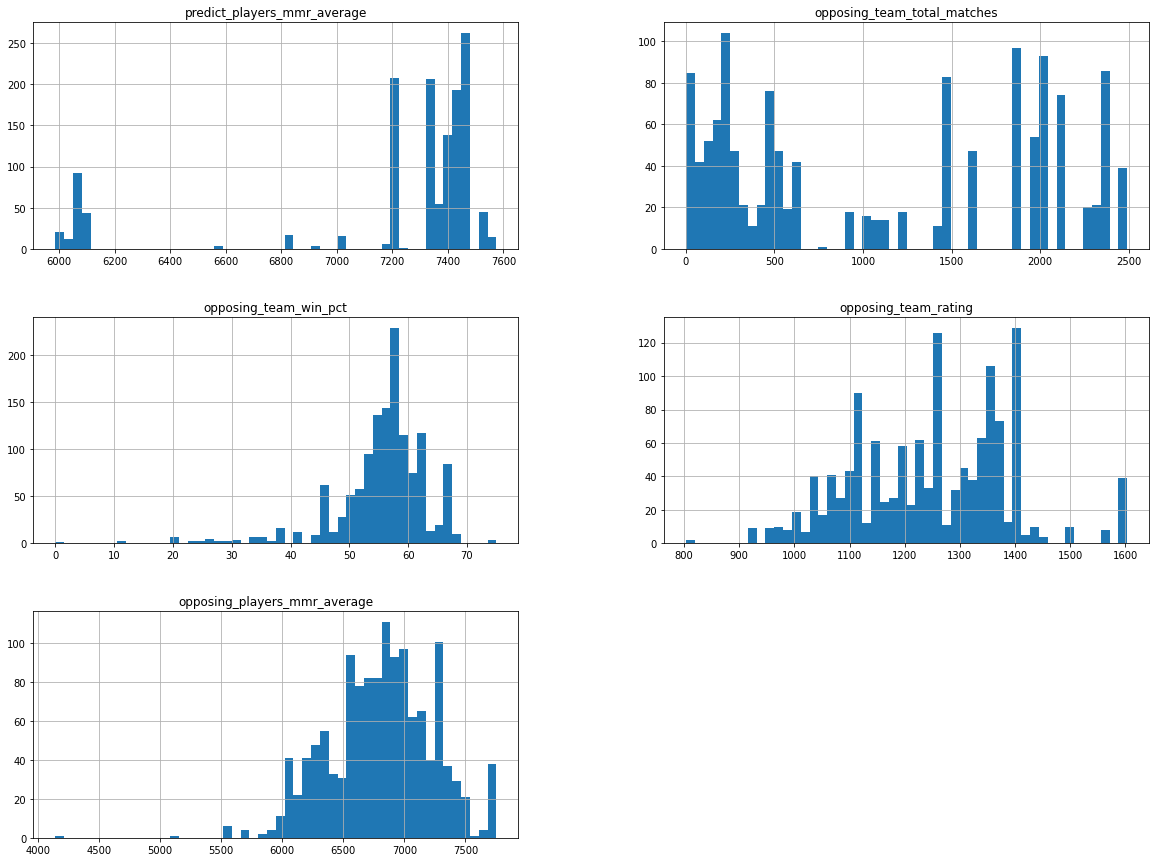

In [17]:
og_team_matches_df.loc[:,['predict_players_mmr_average', 
                   'opposing_team_total_matches', 
                   'opposing_team_win_pct', 
                   'opposing_team_rating', 
                   'opposing_players_mmr_average']].hist(bins = 50, figsize=(20, 15))
plt.show()

In [19]:
og_team_matches_df.columns

Index(['start_date', 'predict_team_name', 'predict_team_id',
       'predict_team_total_matches', 'predict_team_win_pct',
       'predict_team_rating', 'predict_players_mmr_average',
       'opposing_team_name', 'opposing_team_id', 'opposing_team_total_matches',
       'opposing_team_win_pct', 'opposing_team_rating',
       'opposing_players_mmr_average', 'league_name', 'leagueid', 'cluster',
       'radiant_win', 'radiant', 'duration', 'match_id', 'match_outcome'],
      dtype='object')

In [43]:
X = og_team_matches_df.drop(labels = ['match_outcome', 
                                      'start_date', 
                                      'predict_team_name',
                                      'predict_team_id',
                                      'opposing_team_name',
                                      'opposing_team_id',
                                      'league_name',
                                      'leagueid',
                                      'cluster', 
                                      'radiant_win', 
                                      'radiant', 
                                      'match_id'], axis = 1)

y = og_team_matches_df.match_outcome

# Consider scaling the data (Normalisation or Standardisation)

In [44]:
X.head()

,predict_team_total_matches,predict_team_win_pct,predict_team_rating,predict_players_mmr_average,opposing_team_total_matches,opposing_team_win_pct,opposing_team_rating,opposing_players_mmr_average,duration
0,1325,61.66,1554.93,6058.8,903,54.93,1493.25,7204.6,2455
1,1325,61.66,1554.93,6058.8,903,54.93,1493.25,7204.6,2996
2,1325,61.66,1554.93,6058.8,903,54.93,1493.25,7204.6,2776
3,1325,61.66,1554.93,6058.8,1489,66.69,1405.11,6524.6,1628
4,1325,61.66,1554.93,6058.8,1489,66.69,1405.11,6524.6,2547


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [46]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

In [47]:
y_pred = log_reg.predict(X_test)

In [48]:
conf_mtx = confusion_matrix(y_test, y_pred)

In [49]:
conf_mtx

array([[ 35,  59],
       [ 23, 150]], dtype=int64)

In [50]:
precision_score(y_test, y_pred)

0.7177033492822966

In [51]:
recall_score(y_test, y_pred)

0.8670520231213873